# Predicting Clinical Trial Terminations
### Notebook 4.0: Advanced Modelling - Ensemble Learning

**Author: Clement Chan**

---
Notes on the notebook:
- ADD NOTES HERE!!

### Data Dictionary for this notebook that is based on clinicaltrials.gov:

---
| Column | Description                                  |Data Type|
|-------|--------------------------------------------|-------|
| Study Status (**Dependant Variable**)| Binary column, 0 for Completed Trials and 1 for Terminated Trials | int |
| Study Title | Title of the Clinical Trial           | object |
| Brief Summary | Short description of the clinical study (Includes study hypothesis) | object |
| Study Results | Whether the results are posted (yes = 1 or no = 0) | int|
| Conditions | Primary Disease or Condition being studied     | object |
| Primary Outcome Measures | Description of specific primary outcome | object |
| Sponsor | The corporation or agency that initiates the study | object |
| Collaborators | Other organizations that provide support | object |
| Sex | All: No limit on eligibility based on sex, Male: Only male participants, Female: Only female participants | int |
| Age | Age group of participants: ADULT, OLDER_ADULT, CHILD  | int |
| Phases | Clinical trial phase of the study | int |
| Enrollment | Total number of participants in a study | int |
| Funder Type | Government, Industry, or Other | int |
| Study Type | Interventional = 1, Observational = 0 | int |
| Study Design | Study design based on study type | object |
| Study Duration | Length of the entire study in categories | object |
| Locations | Country of where the clinical study was held | object |

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# model_selection
from sklearn.model_selection import train_test_split, GridSearchCV

# scalars
from sklearn.preprocessing import StandardScaler

# ensemble classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# model metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, roc_auc_score, RocCurveDisplay

# pipeline
from sklearn.pipeline import Pipeline

# dimension reduction
from sklearn.decomposition import PCA


# ignores the filter warnings
import warnings
warnings.filterwarnings('ignore')

<a id = 'table'><a/>
## Table of Contents

---
1. [Random Forest Classifier](#random)


**Prepare the datasets** from the updated train and test CSVs

In [2]:
# training set
train_df = pd.read_csv('updated_train_set.csv', index_col=0)
train_df.head()

,Study Results,Study Type,Sex_ALL,Sex_FEMALE,Sex_MALE,Age_ADULT,Age_CHILD,Age_OLDER_ADULT,Phases_EARLY_PHASE1,Phases_NO PHASE,...,POM_week week,POM_weekly,POM_weeks post,POM_weeks treatment,POM_weight,POM_women,POM_worse,POM_worst,POM_zero,Study Status
0,0,1,1,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,1,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# testing set
test_df = pd.read_csv('updated_test_set.csv', index_col=0)
test_df.head()

,Study Results,Study Type,Sex_ALL,Sex_FEMALE,Sex_MALE,Age_ADULT,Age_CHILD,Age_OLDER_ADULT,Phases_EARLY_PHASE1,Phases_NO PHASE,...,POM_week week,POM_weekly,POM_weeks post,POM_weeks treatment,POM_weight,POM_women,POM_worse,POM_worst,POM_zero,Study Status
0,1,1,1,0,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,1,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,1,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,1,0,0,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
# shape of train and test
print(f'Training shape: {train_df.shape}, Test shape: {test_df.shape}')

Training shape: (244088, 2278), Test shape: (61022, 2278)


In [4]:
# training set
X_train = train_df.iloc[:,:2277]
y_train = train_df.iloc[:, -1]

# sanity check
print(X_train.shape, y_train.shape)

(244088, 2277) (244088,)


In [5]:
# testing set
X_test = test_df.iloc[:,:2277]
y_test = test_df.iloc[:, -1]

# sanity check
print(X_test.shape, y_test.shape)

(61022, 2277) (61022,)


<a id = 'random'></a>
## 1. Random Forest Classifier

[back to table of contents](#table)

---

(EXPLAIN WHAT random forest does and why we are using it!!)

**Decision Tree Baseline**
- We will start with a single decision tree model for our dataset as a baseline to evaluate the model performance.
- Since we are classifying terminated and completed trials, we will be focusing on precision, recall, and f1 metrics.

In [7]:
# instantiate dt
dt = DecisionTreeClassifier()

# fit dt
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [9]:
# print the scores
print(f'dt train: {dt.score(X_train, y_train)}')
print(f'dt test: {dt.score(X_test, y_test)}')

dt train: 0.9999836124676347
dt test: 0.8634590803316836


There is definitely some overfitting in the training set as the test accuracy is much lower. We will need to lower the `max_depth` parameter in future models to help prevent overfitting. We can also modify the `min_sample_leaf` parameter which would only split the decision according to the number of leafs. A higher `min_sample_leaf` will make the model more general and could underfit while a lower `min_sample_leaf` would overfit as it splits when there are lower number of leafs.

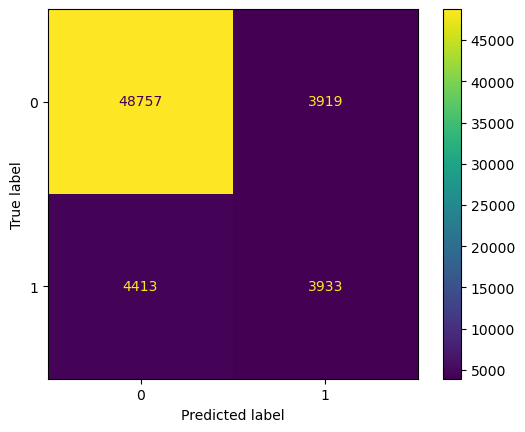

In [10]:
# Get class predictions
y_pred = dt.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [11]:
dt_report = classification_report(y_test, y_pred)
print(dt_report)

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     52676
           1       0.50      0.47      0.49      8346

    accuracy                           0.86     61022
   macro avg       0.71      0.70      0.70     61022
weighted avg       0.86      0.86      0.86     61022



**TP**: The true positive data points are the correctly labelled and predicted positive reviewer scores (Terminated Trials).

**TN**: The true negative data points are the correctly labelled and predicted negative reviewer scores (Completed).

**FP**: Predicted as terminated when it was actually completed.

**FN**: Predicted as completed when it was actually terminated


1. The accuracy is calculated by the sum of (**TP** and **TN**) divided by the whole dataset.
 - The model is overfitting a little bit, but most of the actual terminated and completed trials are classified well.
2. The precision is the proportion of terminated trial predictions that was actually correct and is calculated by dividing the **TP** with (**FP + TP**).
3. The recall score is the proportion of actual terminated trials that was predicted correctly and is calculated by dividing the **TP** with (**FN + TP**).
4. The f1 score is the harmonic mean of the precision and recall scores.

Since both precision and recall scores are important for our analysis, we will focus on f1-scores and `AUC` (area under ROC curve).

The ROC curve is formed from the True Positive Rate and False Positive Rate across multiple probability thresholds. It's useful to use AUC to evaluate the model because it captures both the positive and negative classes from a range of 0 to 1.
- AUC = 0 indicates that the model predicts all scores 100% incorrect. For example, all positive scores as negative, and all negative scores as positive.
- AUC = 0.5 indicates that the model is random and predicts 50% of positive scores as positive, and 50% of negative scores as negative.
- AUC = 1.0 indicates that the model predicts all scores 100% correctly. For example, all positive scores as positive, and all negative scores as negative.  
(source = https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)


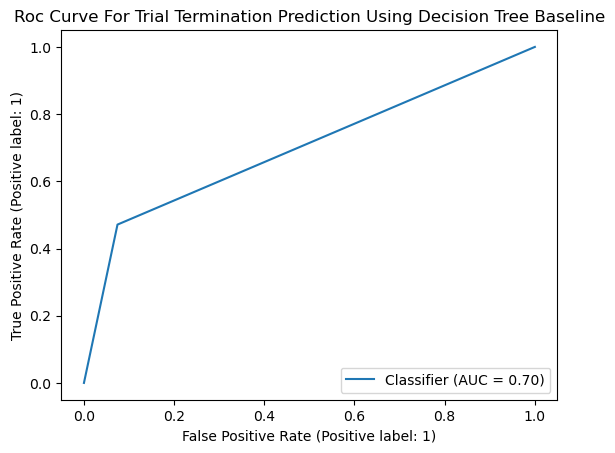

In [12]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title('ROC Curve for Trial termination Prediction using Decision Tree baseline'.title())
plt.show()

Our AUC of 0.70 is not bad as it predicts completed and terminated trials 70% correctly.
| Model | f1-Score                                  | AUC |
|-------|--------------------------------------------|-------|
| Decision Tree | 0.49 | 0.70 |

Now we will look into ensemble learning and combine many decision trees by bagging the data and see how that would affect our metrics.

---

#### Random Forest Classifier (1)
- We will try out a RandomForestClassifier with n_estimators of 10.

In [13]:
# instantiate rmf
rmf = RandomForestClassifier(n_estimators=10)

# fit rmf
rmf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [14]:
print(f'rmf train: {rmf.score(X_train, y_train)}')
print(f'rmf test: {rmf.score(X_test, y_test)}')

rmf train: 0.9871644652748189
rmf test: 0.9029858083969716


There is a ~8% difference between our train and test accuracy which indicates some overfitting. Let's look at the evaulation metrics and then modify the `max_depth` next.

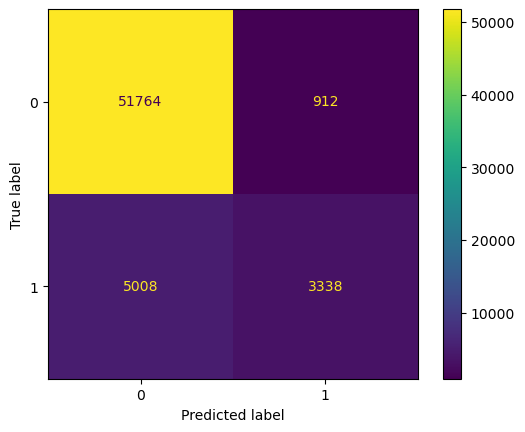

In [15]:
# Get class predictions
y_pred = rmf.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rmf, X_test, y_test)

Our model is predicting a lot of completed trials when they were actually terminated (**True Negative**). This will lead to a much lower recall score.

In [16]:
rmf_report = classification_report(y_test, y_pred)
print(rmf_report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     52676
           1       0.79      0.40      0.53      8346

    accuracy                           0.90     61022
   macro avg       0.85      0.69      0.74     61022
weighted avg       0.89      0.90      0.89     61022



RandomForestClassifier seems to be improving the f1-scores of both completed and terminated trials completed to the baseline decision tree.

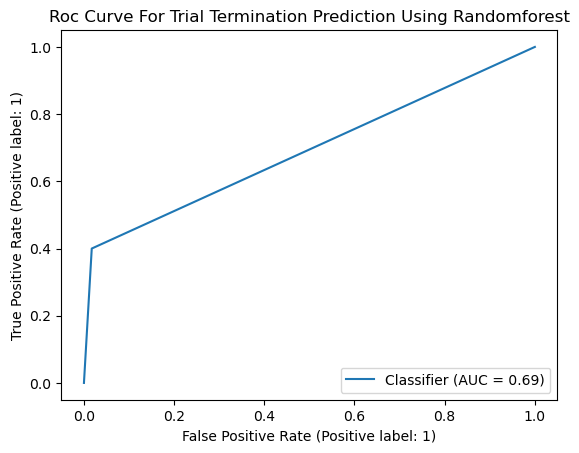

In [17]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title('ROC Curve for Trial termination Prediction using RandomForest'.title())
plt.show()

Interesting to see that although the f1-score got higher, the AUC score dropped by 1%.

---

#### Random Forest Classifier (2)
- We will increase n_estimators=15 to have a more accurate model when ensemble learning.
- look at a range of `max_depth` to see where the model is overfitting.

In [33]:
# depths to look at
deep = [10, 20, 30, 40, 50]

# creating score lists
train_scores = []
test_scores = []
f1 = []
auc = []

for depth in deep:
    # instantiate rmf
    rmf = RandomForestClassifier(n_estimators=15, max_depth=depth)

    # fit rmf
    rmf.fit(X_train, y_train)

    # append accuracy scores
    train_scores.append(rmf.score(X_train, y_train))
    test_scores.append(rmf.score(X_test, y_test))

    # create predictions
    y_predict = rmf.predict(X_test)

    # append f1 and auc scores
    f1.append(f1_score(y_test, y_predict))
    auc.append(roc_auc_score(y_test, y_predict))

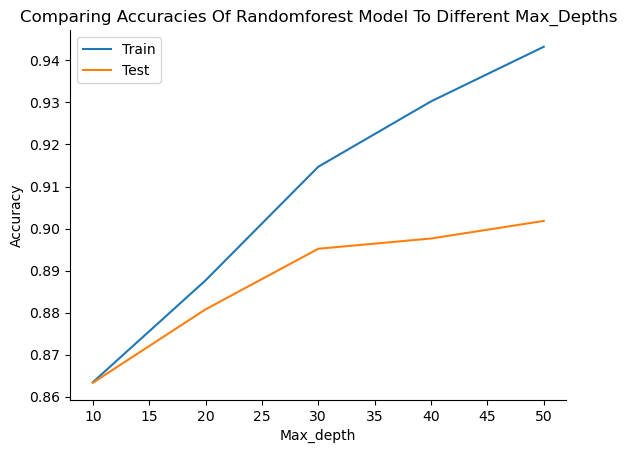

In [34]:
plt.figure()

plt.plot(deep, train_scores, label = 'Train')
plt.plot(deep, test_scores, label = 'Test')

plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.title('Comparing Accuracies of RandomForest Model to different Max_depths'.title())

plt.legend()
sns.despine()
plt.show()

The model seems to start overfitting significantly at Max_depth of 30.

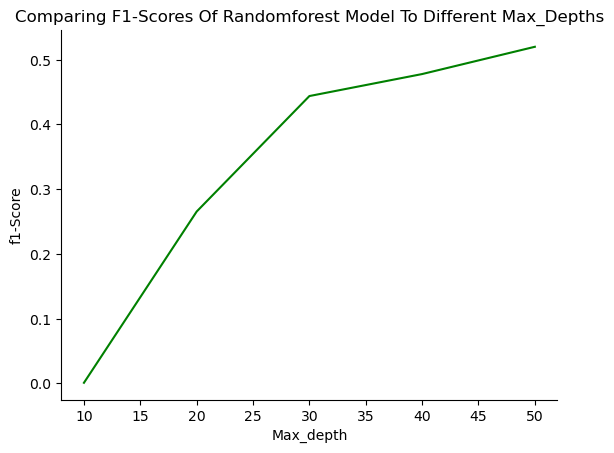

In [39]:
plt.figure()

plt.plot(deep, f1, color='green')

plt.xlabel('Max_depth')
plt.ylabel('f1-Score')
plt.title('Comparing f1-Scores of RandomForest Model to different Max_depths'.title())

sns.despine()
plt.show()

The **f1_score** rises rapidly until a Max_depth of 30 and then slows down but is still increasing.

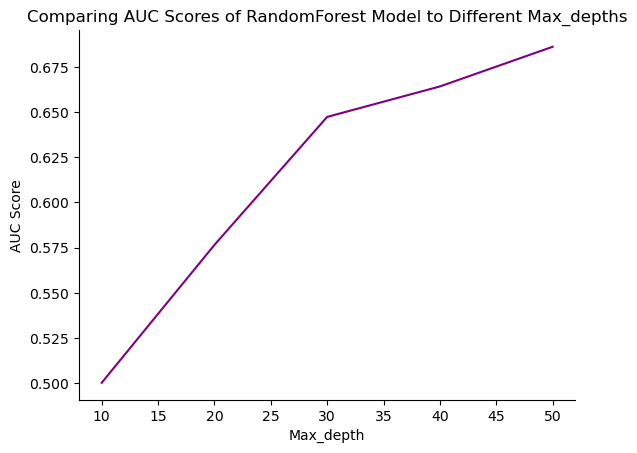

In [42]:
plt.figure()

plt.plot(deep, auc, color='purple')

plt.xlabel('Max_depth')
plt.ylabel('AUC Score')
plt.title('Comparing AUC Scores of RandomForest Model to Different Max_depths')

sns.despine()
plt.show()

Similar to the f1_score, the **AUC Score** rises rapidly until a Max_depth of 30 with a score of ~0.65 and then continues to rise.

**RandomForest Classifier (2) Summary**
- Our goal was to look into ranges of `Max_depth` to prevent overfitting the model.
- We found that Max_depth of 30 is a good place to set our base depth for more parameter tuning.

Next, we will modify the `min_samples_leaf` to see how we can improve the model.

---

#### RandomForest Classifier (3)

min_samples_leaf = 4, 6, 8, 10, 12

In [58]:
# min_samples_leaf to look at
min_leaf = range(4,14, 2)

# creating score lists
train_scores = []
test_scores = []
f1 = []
auc = []

for leaf in min_leaf:
    # instantiate rmf
    rmf = RandomForestClassifier(n_estimators=15, max_depth=30, min_samples_leaf=leaf)

    # fit rmf
    rmf.fit(X_train, y_train)

    # append accuracy scores
    train_scores.append(rmf.score(X_train, y_train))
    test_scores.append(rmf.score(X_test, y_test))

    # create predictions
    y_predict = rmf.predict(X_test)

    # append f1 and auc scores
    f1.append(f1_score(y_test, y_predict))
    auc.append(roc_auc_score(y_test, y_predict))

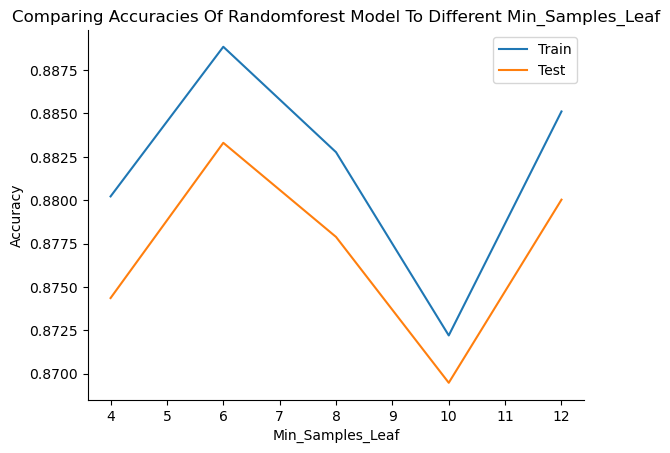

In [59]:
plt.figure()

plt.plot(min_leaf, train_scores, label = 'Train')
plt.plot(min_leaf, test_scores, label = 'Test')

plt.xlabel('Min_Samples_Leaf')
plt.ylabel('Accuracy')
plt.title('Comparing Accuracies of RandomForest Model to different Min_Samples_leaf'.title())

plt.legend()
sns.despine()
plt.show()

Interesting to see the max accuracy for train and test was ~88% at a min_samples_leaf of 6. However, the accuracy when min_samples_leaf of 1 was still higher.

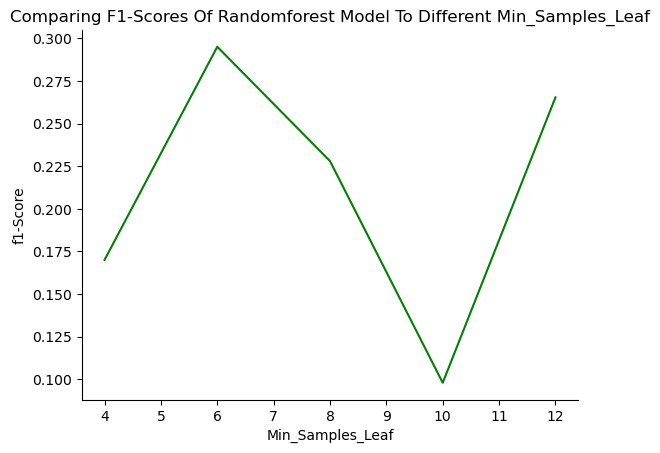

In [62]:
plt.figure()

plt.plot(min_leaf, f1, color='green')

plt.xlabel('Min_Samples_Leaf')
plt.ylabel('f1-Score')
plt.title('Comparing f1-Scores of RandomForest Model to different Min_Samples_Leaf'.title())

sns.despine()
plt.show()

The f1-score was significantly lower than the RandomForest(2) models, meaning that min_samples_leaf of 1 is the best.

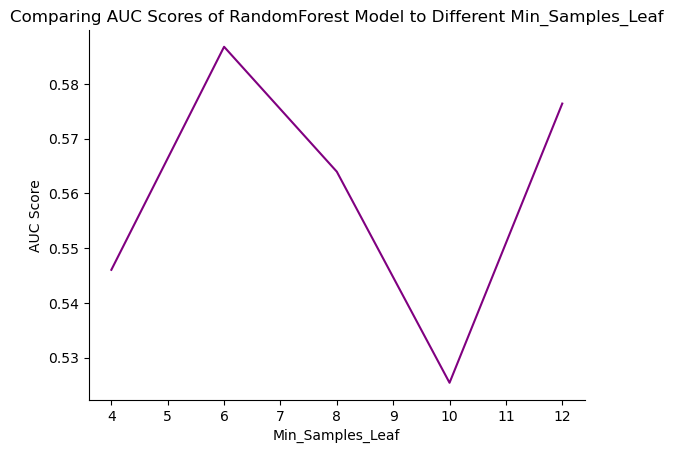

In [63]:
plt.figure()

plt.plot(min_leaf, auc, color='purple')

plt.xlabel('Min_Samples_Leaf')
plt.ylabel('AUC Score')
plt.title('Comparing AUC Scores of RandomForest Model to Different Min_Samples_Leaf')

sns.despine()
plt.show()

Similar with the f1-score graph, the AUC scores underperformed compared to the RandomForest(2) parameters.

---

#### RandomForest Classifier (4)

**Important Notes**
- From our baseline model in notebook 3.0, we found that downsampling the completed trial class helped improve our f1-scores. Let's modify the class_weight and see where our model performs the best.
- We will change n_estimators = 20 to improve the scores and use our baseline max_depth of 30 and default min_samples_leaf = 1.

In [11]:
weights = [1, 2, 3, 4, 5, 6, 7]
f1 = []
auc = []
train_scores = []
test_scores = []

for weight in weights:
    rmf = RandomForestClassifier(n_estimators=20, max_depth=30, class_weight={0:1/weight, 1:1})
    rmf.fit(X_train, y_train)

    # Print class_weights
    print(f'Completed = {round(1/weight, 2)}, Terminated = 1')
    
    # Print accuracy score for train and test
    print(f"Train score: {rmf.score(X_train, y_train)}")
    print(f"Test score: {rmf.score(X_test, y_test)}")

    # Print Classification Report
    y_pred = rmf.predict(X_test)
    upsample_rmf_report = classification_report(y_test, y_pred)
    print(upsample_rmf_report)

    # append scores
    f1.append(f1_score(y_test, y_pred))
    auc.append(roc_auc_score(y_test, y_pred))
    train_scores.append(rmf.score(X_train, y_train))
    test_scores.append(rmf.score(X_test, y_test))
    
    print('--------------------------------------------------------')

Completed = 1.0, Terminated = 1
Train score: 0.9175338402543345
Test score: 0.8975123725869358
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     52676
           1       0.82      0.32      0.46      8346

    accuracy                           0.90     61022
   macro avg       0.86      0.66      0.70     61022
weighted avg       0.89      0.90      0.88     61022

--------------------------------------------------------
Completed = 0.5, Terminated = 1
Train score: 0.924826292156927
Test score: 0.9044770738422209
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     52676
           1       0.76      0.44      0.56      8346

    accuracy                           0.90     61022
   macro avg       0.84      0.71      0.75     61022
weighted avg       0.90      0.90      0.89     61022

--------------------------------------------------------
Completed = 0.33, Terminated = 1
Train scor

The f1-score seems to be improving as the completed trial weight starts dropping. This will give more weight to the terminated class which will improve recall scores, but will decrease precision scores. 

Let's visualize this:

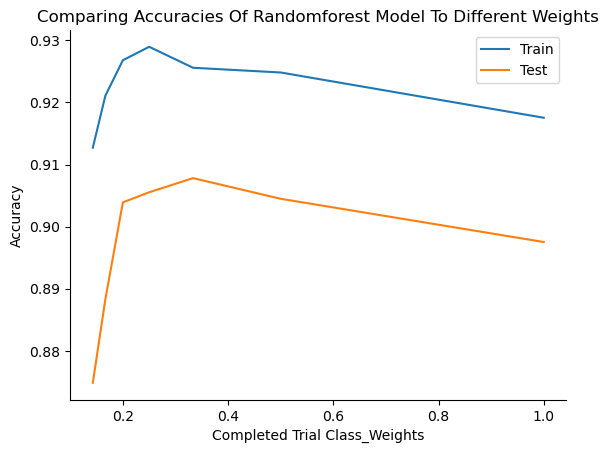

In [12]:
plt.figure()

downsample = [1/i for i in weights]
plt.plot(downsample, train_scores, label = 'Train')
plt.plot(downsample, test_scores, label = 'Test')

plt.xlabel('Completed Trial Class_Weights')
plt.ylabel('Accuracy')
plt.title('Comparing Accuracies of RandomForest Model to different Weights'.title())

plt.legend()
sns.despine()
plt.show()

As the completed trial class_weight decreases, the accuracy is going up and then starts decreasing when class_weight is less than 0.2. This looks really good as our model is not overfitting by much.

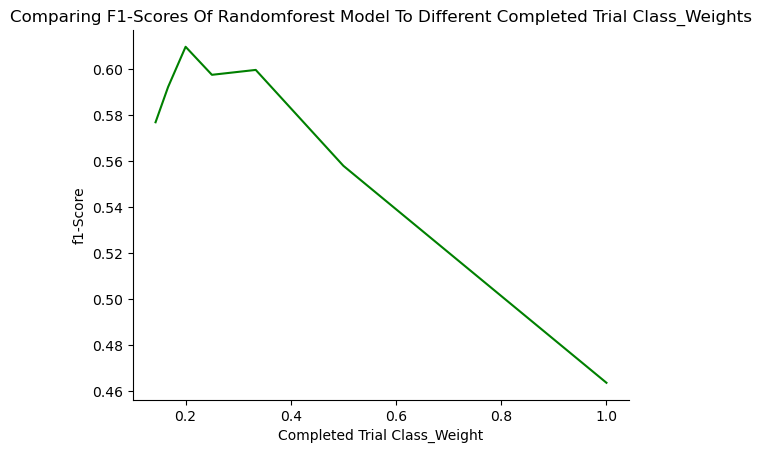

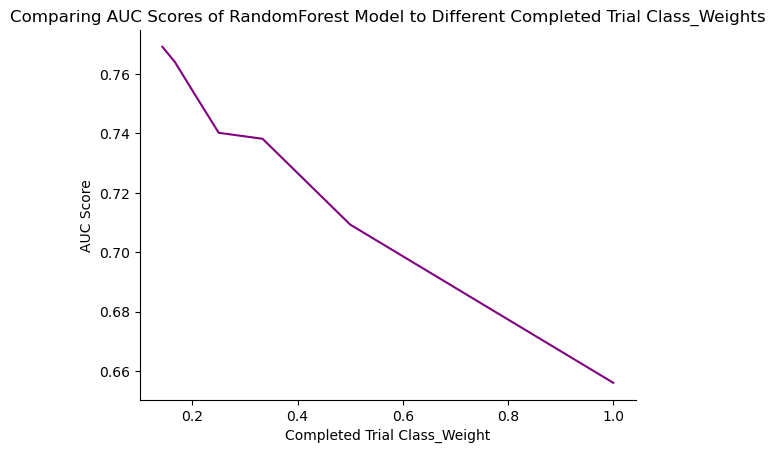

In [13]:
plt.figure()

plt.plot(downsample, f1, color='green')

plt.xlabel('Completed Trial Class_Weight')
plt.ylabel('f1-Score')
plt.title('Comparing f1-Scores of RandomForest Model to different Completed Trial Class_Weights'.title())

sns.despine()
plt.show()


plt.figure()

plt.plot(downsample, auc, color='purple')

plt.xlabel('Completed Trial Class_Weight')
plt.ylabel('AUC Score')
plt.title('Comparing AUC Scores of RandomForest Model to Different Completed Trial Class_Weights')

sns.despine()
plt.show()

When Completed Trial Class_Weight = 0.2, our model has the highest f1-score of 0.61 and has a decent AUC score as well.

In [21]:
print(f" The best Completed Class_Weight is {downsample[-3]} which achieves a f1-score of {f1[-3]} and an AUC score of {auc[-3]}.")
print(f"Train Accuracy: {train_scores[-3]}, Test Accuracy: {test_scores[-3]}")

 The best Completed Class_Weight is 0.2 which achieves a f1-score of 0.6096391958460925 and an AUC score of 0.7544183285630915.
Train Accuracy: 0.9268009898069549, Test Accuracy: 0.9039035102094327


Let's add this to our table since it's the best optimized RandomForest Classifier by hand.

| Model | f1-Score                                  | AUC |
|-------|--------------------------------------------|-------|
| Decision Tree | 0.49 | 0.70 |
| RandomForest Classfier (4) | 0.61 | 0.75 |

---

### RandomForest Classfier - Hyperparameter Optimization

To optimize our hyperparameters of our ensemble model, we will take our previous parameters into account and fine tune the `max_depth` and `min_samples_leaf` to improve our model based on f1 and AUC scores.

**Parameters:**
- We will use our default estimator RandomForestClassifier() with the default n_estimators of 100 to improve learning scores.

In [10]:
estimators = [('rmf', RandomForestClassifier())]

pipe = Pipeline(estimators)

In [11]:
params = {'rmf__class_weight':[{0:0.2, 1:1}],
          'rmf__max_depth':[25, 30, 35],
          'rmf__min_samples_leaf':[1, 5]}

grid_search = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=3, verbose=3)

fitted_search = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=25, rmf__min_samples_leaf=1;, score=0.866 total time= 1.9min
[CV 2/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=25, rmf__min_samples_leaf=1;, score=0.862 total time= 1.9min
[CV 3/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=25, rmf__min_samples_leaf=1;, score=0.861 total time= 1.9min
[CV 1/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=25, rmf__min_samples_leaf=5;, score=0.865 total time= 1.7min
[CV 2/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=25, rmf__min_samples_leaf=5;, score=0.865 total time= 1.7min
[CV 3/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=25, rmf__min_samples_leaf=5;, score=0.864 total time= 1.7min
[CV 1/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=30, rmf__min_samples_leaf=1;, score=0.867 total time= 2.2min
[CV 2/3] END rmf__class_weight={0: 0.2, 1: 1}, rmf__max_depth=30, rmf__min_samp

In [27]:
# best cross validation accuracy
fitted_search.best_score_

0.8693455064486807

In [26]:
# train and test scores
print(f'Train Accuracy: {fitted_search.score(X_train, y_train)}, Test Accuracy: {fitted_search.score(X_test, y_test)}')

Train Accuracy: 0.9346768382623756, Test Accuracy: 0.8670699745135213


The model seems to be overfitting to the training set as the test accuracy is is ~7% lower than the train accuracy. Let's check the `best params` to see why.

In [18]:
fitted_search.best_estimator_

Pipeline(steps=[('rmf',
                 RandomForestClassifier(class_weight={0: 0.2, 1: 1},
                                        max_depth=35, min_samples_leaf=5))])

In [19]:
# can also use .best_params_ to find the optimal parameters
fitted_search.best_params_

{'rmf__class_weight': {0: 0.2, 1: 1},
 'rmf__max_depth': 35,
 'rmf__min_samples_leaf': 5}

As expected, we saw from previous parameters than the model starts overfitting to the training when `max_depth` is greater than 25. However, it is interesting to see that the model performs better with a min_samples_leaf of 5.

Let's evaulate our model further with a confusion matrix.

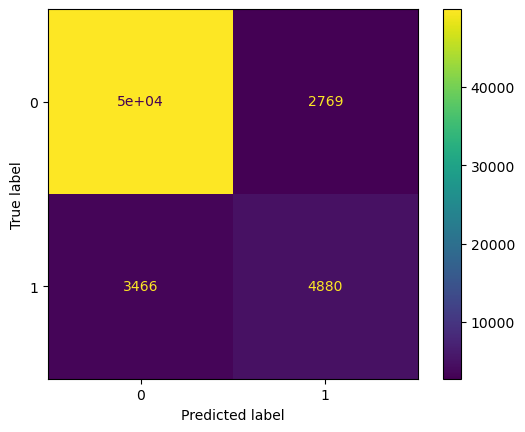

In [29]:
# Get class predictions
y_pred = fitted_search.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(fitted_search, X_test, y_test)

This is already looking much better as our model is classifying more true terminated trials **True Positive**.

Let's view the precision and recall scores in a classification report.

In [30]:
grid_report = classification_report(y_test, y_pred)
print(grid_report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     52676
           1       0.64      0.58      0.61      8346

    accuracy                           0.90     61022
   macro avg       0.79      0.77      0.78     61022
weighted avg       0.89      0.90      0.90     61022



The precision and recall scores improved after hyperparameter tuning which lead to a small increase in f1-score!

In [31]:
print(f'f1_score: {f1_score(y_test, y_pred)}, AUC_score: {roc_auc_score(y_test,y_pred)}')

f1_score: 0.6101906845889341, AUC_score: 0.7660723025778704


| Model | f1-Score                                  | AUC |
|-------|--------------------------------------------|-------|
| Decision Tree (base model) | 0.49 | 0.70 |
| RandomForest Classfier (4) | 0.61 | 0.75 |
| HyperParameter Tuned RandomForest Classfier | 0.61 | 0.77 |

After HyperParameter Tuning, our RandomForest Classifier had a **2%** increase in AUC score. This means that our model is able to classify Actual Terminated and Completed Trials **77%** of the time. This is huge!

<a id = 'sum'></a>
## 4. Summary & Next Steps

[back to table of contents](#table)

---

**Text Preprocessing**
- MARKDOWN
